In [42]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.collections import LineCollection
import seaborn as sns

import trompy as tp
import csv


colors_restricted = "#219C90"
colors_adlib_light = "#9C89B8" 
colors_adlib_dark = "#0059b3"
colors_sucralose = "#af9991"

In [43]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/stats")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_dark.pickle", 'rb') as handle:
    PVH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_light.pickle", 'rb') as handle:
    PVH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    PVH_adlib_sucralose = pickle.load(handle)
    
with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_dark.pickle", 'rb') as handle:
    VMH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_light.pickle", 'rb') as handle:
    VMH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_sucralose.pickle", 'rb') as handle:
    VMH_adlib_sucralose = pickle.load(handle)

In [44]:
def get_list_of_mice(data):

    mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                        "HL202", "HL205", "HL206", "HL211",
                        "HL301", "HL304", "HL305"]
    
    #"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
    #HL 306, 308 have no virus
    #HL301, HL304, HL305 have poor fiber placement
    #HL313 - HL318 are control mice
    
    list_of_mice = []

    for key, val in data.items():
        if val["mouse_ID"] not in list_of_mice and val["mouse_ID"] not in mice_to_exclude:
            list_of_mice.append(val["mouse_ID"])
            
    return list_of_mice

In [45]:
PVH_mice = get_list_of_mice(PVH_restricted_dark)
VMH_mice = get_list_of_mice(VMH_restricted_dark)

all_mice= PVH_mice +VMH_mice

In [46]:
def get_snips(data):
    list_of_mice = get_list_of_mice(data)

    snips_mean_full = []
    mean_licks = []
    mean_runs = []
    mean_licks_in_runs = []
    mean_run_length = []

    kwargs = {"bins": 150, "trial_length": 15, "baseline_length": 5}
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    for mouse in list_of_mice:
        snips_full = []
        licks_in_session = []
        runs_in_session = []
        licks_in_run_in_session = []
        run_length_in_session = []

        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                if len(val["licks"]) < 10:
                    print(f"Skipping {mouse}: not enough licks.")
                    continue

                lickdata = tp.lickCalc(val["licks"], minrunlength=3)
                print(f"Licks for {mouse}: {len(val['licks'])}, Runs found: {len(lickdata['rStart'])}, Length of runs: {lickdata['rTime']}")

                licks_in_session.append(len(val['licks']))
                runs_in_session.append(len(lickdata['rStart']))
                licks_in_run_in_session.extend(lickdata['rLicks'])
                print(licks_in_run_in_session)
                run_length_in_session.extend(lickdata['rTime'])

                if len(lickdata['rStart']) == 0:
                    print(f"No runs found for {mouse}.")
                    continue

                snipper = tp.Snipper(val["corrected"],
                                      lickdata["rStart"],
                                      end=lickdata["rEnd"],
                                      fs=val["fs"],
                                      pre=pre,
                                      post=post,
                                      binlength=binlength,
                                      zscore=True)

                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6, 2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                snips_full.append(snipper.snips)

        try:
            snips_full = np.vstack(snips_full)
            snips_mean_full.append(np.mean(snips_full, axis=0))
            print("Adding this mouse")
            mean_licks.append(np.mean(licks_in_session))
            mean_runs.append(np.mean(runs_in_session))
            mean_licks_in_runs.append(np.mean(licks_in_run_in_session))
            mean_run_length.append(np.mean(run_length_in_session))

        except Exception as e:
            print("No snips to concatenate:", e)

    snips_mean_full = np.array(snips_mean_full)

    return (snips_mean_full, 
            mean_licks,
            mean_runs,
            mean_licks_in_runs,
            mean_run_length)


Licks for HL203: 935, Runs found: 5, Length of runs: [67.45522176, 43.69530880000002, 10.801971199999969, 16.301096959999995, 36.35724288000006]
[324, 310, 28, 105, 166]
<class 'numpy.ndarray'>
Found 0 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)


No artifacts found.
Licks for HL203: 775, Runs found: 8, Length of runs: [23.62408959999999, 26.89908736000001, 24.73918464000002, 14.75002367999997, 0.5649203199999988, 23.332126719999906, 13.780090879999989, 24.544215039999926]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 868, Runs found: 6, Length of runs: [45.96236288, 20.380221440000014, 24.27994111999999, 31.64323840000003, 23.633100799999966, 28.373319679999895]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159, 135, 155, 167, 128, 103, 179]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL204: 1551, Runs found: 26, Length of runs: [10.609786880000001, 3.0430003200000044, 7.114915839999981, 16.45510655999999, 0.30703615999999556, 14.856028159999994, 32.53321728000003, 5.205032959999983, 0.8001945600000226, 18.63221248000002, 4.028006399999981, 19.35114240000007, 1

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL204: 1808, Runs found: 23, Length of runs: [0.9240575999999976, 17.37719808, 32.78110720000001, 37.160222720000036, 45.071892479999974, 21.15305472, 12.885196800000017, 9.609052160000033, 6.416957440000033, 7.87202048000006, 18.793103360000032, 30.56730111999991, 16.412180480000075, 18.25996800000007, 20.239155199999914, 16.48214015999997, 9.097216000000117, 10.638131199999862, 3.0187519999999495, 5.250088960000085, 15.447162880000178, 9.878241280000111, 11.17011967999997]
[61, 6, 5, 108, 4, 106, 163, 13, 6, 129, 3, 119, 9, 91, 10, 9, 135, 99, 8, 97, 12, 13, 86, 92, 8, 153, 8, 29, 121, 181, 169, 73, 86, 42, 45, 37, 118, 118, 103, 100, 105, 97, 40, 61, 16, 24, 88, 61, 81]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL204: 1480, Runs found: 26, Length of runs: [10.190028799999993, 3.1029657599999894, 3.4178662400000235, 7.566950399999996, 2.5247744000000125, 6.845071359999963, 4.6368358400

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL207: 1695, Runs found: 19, Length of runs: [9.53319424, 17.195008, 19.975864320000028, 2.549022719999982, 3.8969344000000206, 15.815147520000039, 21.75729664000005, 15.15618304000003, 22.406103040000062, 20.76737535999996, 27.180892159999985, 2.11419135999995, 7.676067840000087, 13.389004800000066, 0.7077887999998893, 7.928709120000121, 22.065152000000126, 0.6091571199999635, 23.49826048]
[17, 86, 298, 85, 4, 61, 3, 74, 5, 166, 95, 133, 116, 3, 113, 60, 4, 6, 86, 159, 62, 103, 142, 16, 21, 104, 164, 95, 149, 147, 177, 9, 35, 89, 4, 55, 161, 3, 154]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL207: 1758, Runs found: 13, Length of runs: [22.505062399999986, 50.78335487999999, 32.08806400000003, 13.32019200000002, 0.5100339199999553, 29.66306816000008, 10.209198079999965, 5.261230080000132, 26.064322560000164, 20.66497535999997, 9.949020159999918, 31.63422719999994, 24.335155199999917]
[17

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1533, Runs found: 20, Length of runs: [28.04121599999999, 17.538908159999977, 20.39693312, 5.486837759999986, 20.49409023999999, 17.933107199999995, 14.191001599999993, 6.738739199999998, 30.102159359999973, 14.316011519999961, 19.82808063999994, 14.58700288, 3.2271564799999624, 17.835130880000065, 17.803837440000052, 17.37113599999998, 12.378767359999983, 8.73299967999992, 35.39009536000003, 10.345021439999982]
[200, 83, 81, 67, 125, 147, 47, 107, 108, 74, 35, 66, 106, 29, 30, 76, 37, 21, 85, 46, 120, 23, 122, 69, 87, 24, 83, 89, 98, 71, 18, 91, 108, 61, 82, 39, 182, 35]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1747, Runs found: 31, Length of runs: [0.687964160000007, 29.04932352, 6.383042560000007, 14.757068800000013, 32.28925951999997, 40.380334079999955, 0.8921088000000168, 4.457103360000019, 8.35895296000001, 1.6708403200000248, 21.91523840000002, 5.51010303999999, 7.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 2 potential artifacts.
Adding this mouse
Licks for HL209: 1450, Runs found: 14, Length of runs: [56.1152, 33.51527424, 17.771888639999986, 10.027007999999967, 19.219087360000003, 24.13625344000002, 19.472056320000092, 8.018984960000012, 26.367262719999985, 14.765096959999937, 17.938350079999964, 8.580136960000118, 15.44306688000006, 1.0372710399999505]
[235, 157, 96, 63, 90, 136, 134, 56, 165, 98, 42, 65, 107, 6]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 1294, Runs found: 19, Length of runs: [14.12988928, 13.50713343999999, 18.0281344, 1.2671385600000065, 20.951040000000035, 2.359623680000027, 2.663055359999987, 2.0620902400000887, 16.21721088000004, 0.8980070399999249, 17.113087999999948, 9.58398464000004, 16.352542719999974, 7.196180480000066, 14.389903360000062, 9.142272000000048, 0.2079129600001579, 2.0719206399999166, 10.871930880000036]
[235, 157, 96, 63, 90, 136, 134, 56, 165, 98, 42, 65, 107, 6, 106, 109, 147, 9, 158, 20, 16

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL210: 1076, Runs found: 22, Length of runs: [16.338288640000002, 3.832872960000003, 16.470015999999987, 15.120138239999989, 13.859061760000031, 5.873008639999966, 31.548211200000026, 12.521144320000019, 8.041922559999989, 1.4049280000000408, 4.1150054400000045, 11.889213439999935, 0.3891199999999344, 9.358049280000046, 19.70618367999998, 24.344985599999973, 34.03710464000005, 12.64287744000012, 16.478044159999854, 3.0729830399998264, 22.861086720000003, 18.379079679999904]
[77, 27, 73, 15, 39, 11, 61, 34, 60, 10, 28, 40, 4, 30, 56, 70, 145, 17, 89, 4, 93, 92]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL210: 1436, Runs found: 15, Length of runs: [27.024261120000006, 14.892892160000002, 1.7080320000000029, 21.458124800000007, 14.578974719999962, 5.868912639999962, 5.432934400000022, 12.152012799999966, 18.188042240000073, 18.374000640000077, 1.9629670399999668, 13.871022

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL212: 1539, Runs found: 22, Length of runs: [139.32380160000002, 0.03702784000000747, 0.0391577599999664, 28.27108351999999, 0.0391577599999664, 0.03883007999996835, 160.27697152000002, 7.81008896000003, 9.842032639999957, 4.550819840000031, 118.26970624, 0.03883008000002519, 0.0391577599999664, 0.03899392000005264, 0.0391577599999664, 0.03899392000005264, 0.040304640000044856, 218.80815615999995, 41.47216384000012, 21.794160639999973, 1.6361062400001174, 5.292195839999977]
[369, 27, 5, 247, 104, 15, 66, 156, 28, 25, 221, 20, 28, 157, 14, 90, 94, 5, 173, 5, 167, 202, 163, 148, 17, 137, 8, 374, 3, 3, 20, 3, 3, 265, 98, 5, 11, 113, 3, 3, 3, 3, 3, 3, 443, 120, 37, 5, 8]
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)


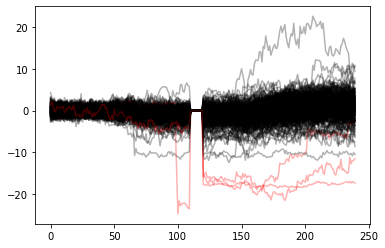

In [47]:
PVH_restricted_full, PVH_restricted_licks, PVH_restricted_runs,  PVH_restricted_licks_in_runs,  PVH_restricted_run_length = get_snips(PVH_restricted_dark)

Licks for HL203: 935, Runs found: 5, Length of runs: [67.45522176, 43.69530880000002, 10.801971199999969, 16.301096959999995, 36.35724288000006]
[324, 310, 28, 105, 166]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 775, Runs found: 8, Length of runs: [23.62408959999999, 26.89908736000001, 24.73918464000002, 14.75002367999997, 0.5649203199999988, 23.332126719999906, 13.780090879999989, 24.544215039999926]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 868, Runs found: 6, Length of runs: [45.96236288, 20.380221440000014, 24.27994111999999, 31.64323840000003, 23.633100799999966, 28.373319679999895]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159, 135, 155, 167, 128, 103, 179]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL204: 1551, Runs found: 26, Length of runs: [10.609786880

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL204: 1480, Runs found: 26, Length of runs: [10.190028799999993, 3.1029657599999894, 3.4178662400000235, 7.566950399999996, 2.5247744000000125, 6.845071359999963, 4.636835840000003, 9.362145279999993, 0.645038080000063, 27.175157759999934, 7.39688448000004, 3.7299814399999605, 16.742973440000014, 0.7405568000000358, 11.112284159999945, 1.079050240000015, 0.5018419200000608, 19.958988800000043, 19.662274560000014, 10.337976319999825, 1.6931225599998925, 12.708085760000131, 0.22298624000018208, 1.8808831999999711, 22.01321471999995, 17.68341504]
[61, 6, 5, 108, 4, 106, 163, 13, 6, 129, 3, 119, 9, 91, 10, 9, 135, 99, 8, 97, 12, 13, 86, 92, 8, 153, 8, 29, 121, 181, 169, 73, 86, 42, 45, 37, 118, 118, 103, 100, 105, 97, 40, 61, 16, 24, 88, 61, 81, 72, 21, 25, 52, 19, 60, 31, 72, 5, 178, 53, 21, 99, 6, 85, 11, 3, 144, 134, 36, 3, 65, 3, 6, 152, 119]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL207: 1576, Runs found: 20, Len

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Adding this mouse
Licks for HL208: 1442, Runs found: 18, Length of runs: [46.91542016, 12.228853759999993, 19.224985600000025, 14.000128000000018, 35.57933056000002, 24.1131519999999, 11.400970239999992, 31.156142079999995, 17.780080639999937, 12.986122239999986, 5.77814527999999, 19.290193919999865, 17.911152639999955, 10.104340480000019, 4.605050879999908, 12.582912000000078, 14.567014400000062, 3.920199679999996]
[200, 83, 81, 67, 125, 147, 47, 107, 108, 74, 35, 66, 106, 29, 30, 76, 37, 21]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1533, Runs found: 20, Length of runs: [28.04121599999999, 17.538908159999977, 20.39693312, 5.486837759999986, 20.49409023999999, 17.933107199999995, 14.191001599999993, 6.738739199999998, 30.102159359999973, 14.316011519999961, 19.82808063999994, 14.58700288, 3.2271564799999624, 17.835130880000065, 17.803837440000052, 17.37113599999998, 12.378767359999983, 8.73299967999992, 35.39009536000003, 10.34502143999

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL209: 1450, Runs found: 14, Length of runs: [56.1152, 33.51527424, 17.771888639999986, 10.027007999999967, 19.219087360000003, 24.13625344000002, 19.472056320000092, 8.018984960000012, 26.367262719999985, 14.765096959999937, 17.938350079999964, 8.580136960000118, 15.44306688000006, 1.0372710399999505]
[235, 157, 96, 63, 90, 136, 134, 56, 165, 98, 42, 65, 107, 6]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 1294, Runs found: 19, Length of runs: [14.12988928, 13.50713343999999, 18.0281344, 1.2671385600000065, 20.951040000000035, 2.359623680000027, 2.663055359999987, 2.0620902400000887, 16.21721088000004, 0.8980070399999249, 17.113087999999948, 9.58398464000004, 16.352542719999974, 7.196180480000066, 14.389903360000062, 9.142272000000048, 0.2079129600001579, 2.0719206399999166, 10.871930880000036]
[235, 157, 96, 63, 90, 136, 134, 56, 165, 98, 42, 65, 107, 6, 106, 109, 147, 9, 158, 20, 16, 13, 124, 8, 115, 59, 112, 52, 111, 73, 3, 10

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL210: 1436, Runs found: 15, Length of runs: [27.024261120000006, 14.892892160000002, 1.7080320000000029, 21.458124800000007, 14.578974719999962, 5.868912639999962, 5.432934400000022, 12.152012799999966, 18.188042240000073, 18.374000640000077, 1.9629670399999668, 13.871022080000103, 19.603128319999996, 24.75409407999996, 20.260126720000017]
[77, 27, 73, 15, 39, 11, 61, 34, 60, 10, 28, 40, 4, 30, 56, 70, 145, 17, 89, 4, 93, 92, 116, 62, 8, 162, 116, 30, 33, 110, 130, 116, 16, 101, 118, 184, 134]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL210: 1284, Runs found: 13, Length of runs: [5.6100454400000075, 21.025095679999993, 16.90796032, 18.09006592, 32.31694848000001, 17.175183360000062, 26.646282240000005, 14.914191360000018, 13.929021440000042, 20.82603008000001, 14.597980160000134, 13.375078399999893, 12.551946240000007]
[77, 27, 73, 15, 39, 11, 61, 34, 60, 10, 28, 40, 4, 30, 56, 70, 145, 17, 89, 4, 93, 92, 116, 62, 8, 162, 116, 30, 33

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 1215, Runs found: 5, Length of runs: [55.08136959999999, 34.22814208, 34.44228095999995, 25.682083839999905, 37.49822463999999]
[181, 191, 17, 140, 148, 371, 235, 244, 191, 174]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL204: 1281, Runs found: 14, Length of runs: [4.495114239999992, 18.369085439999992, 14.859141120000004, 15.317073919999984, 18.421186560000024, 41.740369920000035, 4.054220800000053, 84.36744191999992, 1.0189209600000595, 21.866086400000086, 15.854141440000149, 10.238033920000134, 12.554076160000022, 23.56510719999983]
[37, 126, 101, 113, 145, 106, 4, 203, 3, 149, 106, 10, 42, 127]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL204: 1692, Runs found: 25, Length of runs: [3.4734080000000063, 0.6760038399999928, 25.810206719999996, 14.557020160000036, 20.89500671999997, 0.038010880000001634, 0.03293183999994653

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL207: 1444, Runs found: 9, Length of runs: [4.108779519999985, 1.2841779199999905, 385.90808064000004, 180.7279718399999, 72.19642367999995, 20.643348479999986, 66.19725824000011, 38.045286399999895, 7.660830719999922]
[155, 7, 156, 8, 214, 25, 5, 160, 215, 277, 26, 11, 687, 193, 41, 16, 109, 296, 43]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL208: 1140, Runs found: 14, Length of runs: [25.459261440000006, 28.80421887999998, 40.76224511999999, 21.48827136, 10.488053760000014, 5.695242240000027, 13.269073919999983, 15.083274240000037, 9.297756160000063, 6.182830080000031, 31.078973440000027, 18.420039679999945, 23.311974400000054, 14.017003520000117]
[78, 142, 187, 83, 34, 25, 77, 67, 40, 16, 122, 87, 109, 73]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1671, Runs found: 9, Length of runs: [41.288171520000006, 20.1202073599

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL209: 965, Runs found: 9, Length of runs: [6.399098879999997, 19.991101440000023, 0.2557542399999875, 29.850173439999992, 29.168271360000062, 13.883965439999997, 18.225889280000047, 18.46607872000004, 16.295034880000003]
[20, 133, 3, 187, 183, 81, 133, 122, 100]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 982, Runs found: 13, Length of runs: [6.4171212800000035, 1.7340825599999903, 1.2920422400000007, 19.530219520000003, 9.344122879999986, 0.27082752000001165, 19.355074560000048, 17.65801983999995, 27.308195840000053, 17.020190720000073, 16.054026239999985, 0.42680319999999483, 20.831109120000065]
[20, 133, 3, 187, 183, 81, 133, 122, 100, 48, 12, 11, 142, 67, 3, 126, 122, 137, 109, 95, 4, 105]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL210: 809, Runs found: 7, Length of runs: [21.943091199999998, 24.15820

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL212: 583, Runs found: 4, Length of runs: [1.5189606399999889, 0.038010880000001634, 26.311065600000006, 68.66550783999992]
[77, 177, 442, 3, 3, 145, 432]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL203: 281, Runs found: 4, Length of runs: [34.72113664, 10.320117760000016, 13.014958079999928, 26.407895039999858]
[202, 13, 30, 36]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 367, Runs found: 4, Length of runs: [31.003279359999965, 28.80733183999996, 31.3971507199999, 27.24216832000002]
[202, 13, 30, 36, 83, 134, 88, 62]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 494, Runs found: 6, Length of runs: [29.393223680000006, 9.776988159999974, 13.626081279999994, 0.7200768000000153, 38.955253760000005, 17.057054719999996]
[202, 13, 30, 36, 83, 134, 88, 62, 154, 47, 64, 5, 163, 60]
<clas

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL207: 562, Runs found: 5, Length of runs: [5.413109760000026, 19.200081920000002, 23.853957120000018, 20.626145280000173, 35.23821567999994]
[22, 106, 134, 142, 155]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL207: 1030, Runs found: 14, Length of runs: [9.815982079999998, 5.0180915199999845, 24.67102719999997, 8.732999680000034, 2.349957119999999, 20.701020159999985, 9.36394752000001, 12.680069120000098, 0.431063039999799, 19.76205312000002, 6.1520281600001, 21.598208000000113, 16.907141120000006, 0.6769868799999585]
[22, 106, 134, 142, 155, 70, 21, 190, 69, 6, 145, 71, 35, 3, 127, 26, 145, 114, 7]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL207: 788, Runs found: 8, Length of runs: [8.922890240000015, 23.695196160000023, 1.7301503999999568, 17.807933439999942, 18.2840524799999, 1.185873919999949, 14.753136640000093, 24.45508608]

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


[9, 52, 79, 52, 91, 22, 19, 70]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL210: 291, Runs found: 3, Length of runs: [16.043212799999992, 44.49026047999996, 18.38710784]
[9, 52, 79, 52, 91, 22, 19, 70, 94, 96, 101]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL212: 537, Runs found: 6, Length of runs: [38.02824704, 2.6522419200000513, 18.945146879999925, 30.716395519999992, 1.3651148799999646, 13.917061119999971]
[183, 17, 31, 200, 10, 93]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL212: 527, Runs found: 5, Length of runs: [6.189875200000017, 4.7418572799999765, 26.417070079999974, 25.710264319999965, 43.62616832000003]
[183, 17, 31, 200, 10, 93, 7, 5, 170, 117, 226]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL212: 944, Runs found: 6, Length of runs: [24.65595392, 22.63023615999998, 28.188180480000028, 37.454

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
Licks for HL203: 308, Runs found: 14, Length of runs: [12.250972160000003, 2.4959385600000132, 0.6560153600000262, 5.8171391999999855, 5.155061759999967, 12.45937663999996, 2.0838809599999877, 3.6718182399999932, 0.7689011200000095, 4.61799424000003, 4.202004480000028, 6.615039999999908, 6.077153279999948, 9.92903167999998]
[48, 21, 17, 10, 18, 17, 9, 30, 22, 14, 20, 77, 14, 5, 26, 24, 53, 6, 16, 4, 11, 21, 33, 8, 9]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL204: 267, Runs found: 14, Length of runs: [0.754974720000007, 4.113858559999983, 3.2881049599999983, 8.457912319999991, 2.249031679999973, 8.473149439999986, 16.058941440000012, 6.273925120000058, 1.004011519999949, 8.596029439999938, 8.48510976, 2.40812032000008, 3.292037120000032, 7.508131840000033]
[7, 16, 9, 36, 15, 15, 6, 27, 5, 48, 45, 3, 20, 10]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL204: 210, Runs f

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


[3, 29, 13, 18, 61, 7, 14, 5, 8, 24, 6, 26, 25, 24, 10, 12, 24, 39, 31, 15, 17, 6, 3, 4, 30, 20, 6, 5, 9, 20, 5, 3, 19, 38, 8, 19, 9, 3, 17, 14, 52, 25, 4, 8, 12, 9, 7, 6, 32, 8, 5, 7, 7, 6, 18, 13, 15, 3, 58, 4, 7, 7]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL209: 180, Runs found: 14, Length of runs: [3.7540659200000164, 1.3968998400000032, 5.063966719999996, 9.289072639999972, 2.9270016000000396, 0.40697855999997046, 4.63601663999998, 1.1331174399999782, 5.465047039999945, 0.7079526400000304, 3.079045120000046, 5.582028799999989, 0.4308992000001126, 2.4199167999997826]
[14, 8, 25, 9, 4, 3, 17, 7, 35, 7, 18, 11, 3, 4]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 84, Runs found: 7, Length of runs: [12.36303872000002, 4.231987200000049, 3.8479462400000557, 0.6679756799999268, 1.1298406400001113, 1.2591104000000541, 3.703930879999916]
[14, 8, 25, 9, 4, 3, 17, 7, 35, 7, 18, 11, 3, 4,

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


No artifacts found.
Licks for HL302: 1184, Runs found: 16, Length of runs: [9.00923392, 6.150062079999998, 25.908019200000012, 43.99726591999999, 25.712885760000006, 22.97020415999998, 17.250058239999987, 25.614090239999996, 13.959167999999977, 10.49886719999995, 11.863982080000028, 10.014064639999901, 5.726044159999901, 3.0410342400000445, 24.750161919999982, 13.77714175999995]
[221, 164, 94, 18, 48, 156, 157, 109, 26, 23, 52, 42, 32, 85, 71, 166, 129, 14, 22, 56, 5, 40, 69, 21, 97, 209, 125, 59, 86, 80, 41, 51, 71, 42, 19, 23, 110, 80]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 769, Runs found: 9, Length of runs: [9.975070719999962, 18.918932480000024, 14.664990719999992, 11.336089599999923, 52.487290880000046, 15.873146880000036, 20.306165759999885, 15.257272319999856, 18.82128383999998]
[221, 164, 94, 18, 48, 156, 157, 109, 26, 23, 52, 42, 32, 85, 71, 166, 129, 14, 22, 56, 5, 40, 69, 21, 97, 209, 125, 59, 86, 80, 41, 51, 71, 42, 19, 2

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 1 potential artifacts.
Licks for HL303: 1602, Runs found: 21, Length of runs: [20.2579968, 7.312015359999975, 11.929026560000011, 76.82424831999998, 0.5888409599999704, 28.390031359999966, 36.882350079999924, 49.01240831999996, 18.19623424000008, 23.19319040000005, 39.15022335999993, 1.9690291199999592, 0.30687231999991127, 1.1159142399999382, 18.95104511999989, 39.65714432000004, 5.144084479999947, 11.753226240000004, 0.9528934400000253, 13.667041279999921, 7.594967040000029]
[432, 41, 12, 22, 153, 289, 146, 195, 93, 67, 48, 134, 14, 74, 28, 26, 17, 108, 127, 25, 421, 17, 41, 44, 88, 61, 36, 47, 221, 3, 138, 157, 181, 66, 113, 126, 9, 4, 9, 102, 152, 28, 54, 6, 59, 25]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL307: 1441, Runs found: 17, Length of runs: [25.092096000000026, 39.03930367999999, 1.156874240000036, 64.221184, 25.29820671999994, 12.70415360000004, 4.103045120000047, 8.975319040000045, 12.413173760000063, 20.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
Licks for HL307: 1276, Runs found: 13, Length of runs: [51.502284799999984, 10.180034560000024, 1.4349107200000049, 36.17734655999999, 23.94914816000005, 18.87502336, 21.321154560000082, 9.597091840000076, 19.699138559999938, 10.293084160000035, 15.960965120000083, 17.212047360000042, 16.109076479999885]
[136, 167, 7, 323, 120, 62, 30, 37, 92, 61, 60, 85, 33, 47, 71, 23, 87, 102, 70, 77, 122, 118, 136, 70, 107, 88, 72, 17, 11, 111, 100, 57, 242, 19, 9, 185, 138, 121, 140, 41, 68, 75, 62, 114, 62]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL309: 877, Runs found: 6, Length of runs: [2.8650700800000095, 47.917137920000016, 12.918128639999964, 35.712204799999995, 44.973260799999935, 27.598028800000066]
[15, 261, 96, 136, 239, 129]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL309: 1071, Runs found: 8, Length of runs: [13.937049599999995, 27.758100479999996, 25.6942080000000

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL310: 852, Runs found: 10, Length of runs: [27.651112960000006, 7.3580544000000145, 33.89620224000004, 20.547010560000047, 20.953169919999937, 17.427333119999957, 15.049031679999985, 22.456074240000135, 3.567124480000075, 18.154127359999848]
[88, 290, 52, 102, 15, 13, 44, 25, 59, 99, 14, 91, 29, 238, 47, 95, 92, 90, 70, 16, 82]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL310: 2610, Runs found: 27, Length of runs: [7.568097280000018, 22.740992000000006, 24.56518656000003, 8.215920640000036, 14.050099199999977, 44.679168000000004, 11.444224000000077, 62.92635647999998, 1.4640742399999453, 9.651814399999921, 5.182914559999972, 10.00095743999998, 1.6180838399999402, 13.7781248, 5.603983360000029, 0.45596672000010585, 2.2778675199999725, 3.6049715199999355, 94.45048320000001, 64.87932927999987, 29.775134720000096, 18.613043199999993, 15.277916159999904, 22.973153279999906, 7.098859520000133,

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


[145, 212, 6, 99, 108, 102, 38, 11, 42, 3, 73, 66, 11, 59, 71, 107, 111, 98, 10, 84]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL311: 964, Runs found: 20, Length of runs: [25.841008640000013, 20.46705664000001, 0.3960012800000072, 23.86034688000001, 10.481008640000027, 7.9298559999999725, 3.8587596799999915, 12.485099520000063, 6.5721139199999925, 8.455946240000003, 5.897093120000022, 18.284052480000014, 7.175045119999822, 7.189790720000019, 20.032225280000148, 14.202142719999983, 5.723095039999862, 17.5090892799999, 17.02117376000001, 0.598015999999916]
[145, 212, 6, 99, 108, 102, 38, 11, 42, 3, 73, 66, 11, 59, 71, 107, 111, 98, 10, 84, 94, 103, 4, 100, 61, 44, 15, 42, 48, 23, 15, 51, 41, 19, 81, 73, 14, 77, 50, 4]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL311: 1616, Runs found: 25, Length of runs: [22.727065600000003, 13.961953279999989, 5.382799359999979, 18.306007039999997, 14.33206783999998, 20.15

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper

Found 0 potential artifacts.
No artifacts found.
Licks for HL312: 1381, Runs found: 16, Length of runs: [15.325102079999994, 16.451010559999986, 2.8688384000000156, 17.129963520000047, 8.904212479999956, 2.055864320000012, 8.877998079999998, 25.98207487999997, 12.151029760000029, 16.857989119999957, 17.559060480000085, 10.236887040000056, 0.6419251199999962, 17.704058880000048, 18.91024895999999, 17.862000639999906]
[89, 110, 117, 97, 131, 34, 20, 189, 5, 95, 234, 66, 98, 93, 85, 20, 83, 54, 17, 58, 192, 60, 122, 125, 68, 5, 136, 133, 130]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL312: 1431, Runs found: 14, Length of runs: [23.844126719999963, 0.704020479999997, 20.678082560000007, 0.7340032000000178, 0.819036159999996, 32.52715520000004, 19.64212224000005, 24.640061439999954, 13.46207744000003, 18.354176000000052, 15.397191679999878, 25.848053759999857, 27.417149440000003, 13.326090239999985]
[89, 110, 117, 97, 131, 34, 20, 189, 5, 95, 234, 6

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL303: 1030, Runs found: 13, Length of runs: [17.398988799999984, 34.98704896000004, 15.934914560000038, 9.154068479999978, 19.842170880000026, 22.172958719999997, 9.348055039999963, 3.2428851199999826, 11.807293439999967, 27.086028800000122, 19.984220160000177, 15.190097919999971, 11.890196479999986]
[122, 12, 107, 3, 74, 70, 3, 80, 94, 53, 80, 19, 84, 93, 69, 106, 181, 89, 24, 105, 116, 28, 12, 48, 135, 75, 60, 49]
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding this mouse
Licks for HL307: 565, Runs found: 10, Length of runs: [7.215022079999983, 5.567119359999992, 15.959162880000008, 3.7981388800000104, 2.39091712000004, 20.599111679999965, 0.9560063999999784, 13.53908223999997, 16.974151679999977, 8.974008320000166]
[47, 23, 119, 20, 10, 135, 4, 66, 99, 42]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL307: 722, Runs found: 9, Length of runs: [1.6541286400000104, 17.92589823999998, 18.51392000000004, 18.41201152000008, 5.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL310: 1032, Runs found: 14, Length of runs: [32.68509695999998, 13.75600639999999, 40.78419967999997, 11.24810752000002, 10.912071679999997, 13.304135680000059, 6.529187839999963, 9.975070719999962, 14.50704896000002, 0.5998182400001042, 12.57996288000004, 14.454128639999908, 10.30995968000002, 12.01602559999992]
[51, 133, 10, 153, 94, 39, 67, 67, 86, 27, 55, 54, 63, 202, 104, 139, 39, 66, 84, 16, 41, 88, 3, 52, 82, 70, 45]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL311: 876, Runs found: 13, Length of runs: [34.093137920000004, 16.706109439999977, 14.357135359999972, 5.738987520000023, 9.066905600000041, 31.156142079999995, 30.355128320000063, 27.149107200000003, 19.995197439999856, 0.5157683200000065, 14.246051840000064, 15.735029759999861, 157.02179840000008]
[182, 122, 48, 18, 39, 99, 39, 59, 26, 5, 65, 110, 48]
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Licks for HL311: 599, Runs found: 9, Length of r

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 326, Runs found: 2, Length of runs: [45.732167679999975, 29.664215040000045]
[93, 208, 196, 130]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 631, Runs found: 8, Length of runs: [14.32993792000002, 17.924095999999963, 11.223695360000079, 16.24211455999989, 6.589972479999915, 14.060093440000173, 7.221084160000146, 18.727075839999998]
[93, 208, 196, 130, 94, 123, 90, 106, 15, 95, 16, 92]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL303: 552, Runs found: 6, Length of runs: [15.229091840000024, 42.528112639999904, 36.240261120000014, 27.613921280000113, 3.293183999999883, 5.329059840000127]
[48, 151, 177, 143, 8, 23]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL303: 841, Runs found: 12, Length of runs: [16.75001856, 14.140047359999983, 17.981112320000022, 2.549022720000039, 14.1420134

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


No artifacts found.
Licks for HL312: 256, Runs found: 2, Length of runs: [19.080151040000146, 24.785223679999945]
[167, 124, 131]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL312: 291, Runs found: 5, Length of runs: [0.8229683200000295, 16.233922559999996, 21.494169600000077, 6.317178880000029, 1.7889689600001475]
[167, 124, 131, 5, 83, 148, 40, 14]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL302: 267, Runs found: 17, Length of runs: [9.685893120000003, 6.464962560000004, 5.052006399999982, 14.810152959999982, 28.791439359999913, 17.842175999999995, 3.0729830400000537, 3.9169228800000155, 0.6062080000000378, 5.297111040000118, 6.340935679999802, 0.9910681599999407, 9.48994047999986, 6.038978560000032, 2.867036159999998, 9.218129920000138, 5.85809919999997]
[22, 17, 11, 17, 34, 16, 4, 17, 3, 19, 24, 6, 5, 6, 11, 15, 37]
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding this mous

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Licks for HL312: 236, Runs found: 14, Length of runs: [5.426053120000006, 5.316935679999915, 7.4889625600000045, 11.832033280000019, 1.037107199999923, 5.975244800000155, 2.73809408000011, 7.359201279999979, 1.891041279999854, 2.210856960000001, 7.770112000000154, 0.6940262400000847, 6.748241920000055, 6.408110080000142]
[25, 19, 6, 18, 8, 12, 9, 3, 3, 6, 44, 3, 42, 36]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse


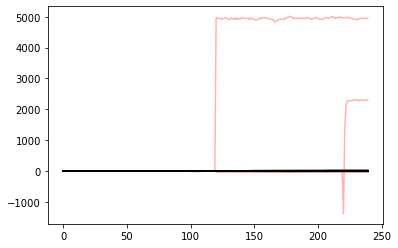

In [48]:
PVH_restricted_full, PVH_restricted_licks, PVH_restricted_runs, PVH_restricted_licks_in_runs, PVH_restricted_run_length = get_snips(PVH_restricted_dark)
PVH_dark_full, PVH_dark_licks, PVH_dark_runs, PVH_dark_licks_in_runs, PVH_dark_run_length = get_snips(PVH_adlib_dark)
PVH_light_full, PVH_light_licks, PVH_light_runs, PVH_light_licks_in_runs, PVH_light_run_length = get_snips(PVH_adlib_light)
PVH_sucralose_full, PVH_sucralose_licks, PVH_sucralose_runs, PVH_sucralose_licks_in_runs, PVH_sucralose_run_length = get_snips(PVH_adlib_sucralose)

VMH_restricted_full, VMH_restricted_licks, VMH_restricted_runs, VMH_restricted_licks_in_runs, VMH_restricted_run_length = get_snips(VMH_restricted_dark)
VMH_dark_full, VMH_dark_licks, VMH_dark_runs, VMH_dark_licks_in_runs,  VMH_dark_run_length = get_snips(VMH_adlib_dark)
VMH_light_full, VMH_light_licks, VMH_light_runs, VMH_light_licks_in_runs, VMH_light_run_length = get_snips(VMH_adlib_light)
VMH_sucralose_full, VMH_sucralose_licks, VMH_sucralose_runs, VMH_sucralose_licks_in_runs, VMH_sucralose_run_length = get_snips(VMH_adlib_sucralose)

In [49]:
#COMBINED LICKS
restricted_licks = np.array(PVH_restricted_licks +VMH_restricted_licks)
dark_licks = np.array(PVH_dark_licks+ VMH_dark_licks)
light_licks = np.array(PVH_light_licks+ VMH_light_licks)
sucralose_licks = np.array(PVH_sucralose_licks+ VMH_sucralose_licks)

# COMBINED RUN NUMBER

restricted_runs = np.array(PVH_restricted_runs+VMH_restricted_runs)
dark_runs = np.array(PVH_dark_runs+ VMH_dark_runs)
light_runs = np.array(PVH_light_runs+ VMH_light_runs)
sucralose_runs = np.array(PVH_sucralose_runs+ VMH_sucralose_runs)

# COMBINED RUN LENGTH

restricted_run_length = np.array(PVH_restricted_run_length +VMH_restricted_run_length)
dark_run_length = np.array(PVH_dark_run_length+ VMH_dark_run_length)
light_run_length = np.array(PVH_light_run_length +VMH_light_run_length)
sucralose_run_length = np.array(PVH_sucralose_run_length+ VMH_sucralose_run_length)

# COMBINED LICKS IN RUNS

restricted_licks_in_runs= np.array(PVH_restricted_licks_in_runs +VMH_restricted_licks_in_runs)
dark_licks_in_runs = np.array(PVH_dark_licks_in_runs+ VMH_dark_licks_in_runs)
light_licks_in_runs = np.array(PVH_light_licks_in_runs +VMH_light_licks_in_runs)
sucralose_licks_in_runs = np.array(PVH_sucralose_licks_in_runs+ VMH_sucralose_licks_in_runs)

In [50]:
# Create a dictionary with your combined arrays
data = {
    'restricted_licks': restricted_licks,
    'dark_licks': dark_licks,
    'light_licks': light_licks,
    'sucralose_licks': sucralose_licks,
    'restricted_runs': restricted_runs,
    'dark_runs': dark_runs,
    'light_runs': light_runs,
    'sucralose_runs': sucralose_runs,
    'restricted_run_length': restricted_run_length,
    'dark_run_length': dark_run_length,
    'light_run_length': light_run_length,
    'sucralose_run_length': sucralose_run_length,
    'restricted_licks_in_runs': restricted_licks_in_runs,
    'dark_licks_in_runs': dark_licks_in_runs,
    'light_licks_in_runs': light_licks_in_runs,
    'sucralose_licks_in_runs': sucralose_licks_in_runs
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

file_path = STATSFOLDER / 'behavior_data_ALL.csv'

#df.to_csv(file_path, index=False)

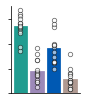

In [51]:
f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_licks,
                light_licks,
                dark_licks,
                sucralose_licks],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
#ax.set_ylim([0, 1800])
ax.set_yticks([0, 500, 1000, 1500])

f.savefig(FIGSFOLDER / "licks_per_session_ALL_2.pdf")

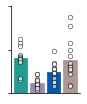

In [52]:
f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_runs,
                light_runs,
                dark_runs,
                sucralose_runs],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
ax.set_ylim([0, 40])
ax.set_yticks([0, 20, 40])

f.savefig(FIGSFOLDER / "runs_per_session_ALL_2.pdf")

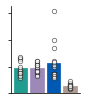

In [53]:
f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_run_length,
                light_run_length,
                dark_run_length,
                sucralose_run_length],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

f.savefig(FIGSFOLDER / "run_length_per_session_ALL_2.pdf")

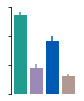

In [208]:
# average licks per session
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(restricted_licks),
        np.mean(light_licks),
        np.mean(dark_licks),
        np.mean(sucralose_licks)
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [restricted_licks,
                             light_licks,
                            dark_licks,
                            sucralose_licks
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
ax.set_ylim([0, 1500])
ax.set_yticks([0, 500, 1000, 1500])
ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    

f.savefig(FIGSFOLDER / "licks_per_session_ALL.pdf")


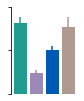

In [209]:
# average number of runs per session
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(restricted_runs),
        np.mean(light_runs),
        np.mean(dark_runs),
        np.mean(sucralose_runs)
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [restricted_runs,
                             light_runs,
                            dark_runs,
                            sucralose_runs
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
ax.set_ylim([0, 20])
ax.set_yticks([0, 10, 20])
ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    

f.savefig(FIGSFOLDER / "runs_per_session_ALL.pdf")


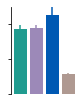

In [211]:
# average length of runs per session
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(restricted_run_length),
        np.mean(light_run_length),
        np.mean(dark_run_length),
        np.mean(sucralose_run_length)
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [restricted_run_length,
                             light_run_length,
                            dark_run_length,
                            sucralose_run_length
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
ax.set_ylim([0, 25])
ax.set_yticks([0, 10, 20])
ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    

f.savefig(FIGSFOLDER / "run_length_per_session_ALL.pdf")


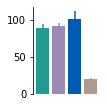

In [202]:
# average licks per run
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(restricted_licks_in_runs),
        np.mean(light_licks_in_runs),
        np.mean(dark_licks_in_runs),
        np.mean(sucralose_licks_in_runs)
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [restricted_licks_in_runs,
                             light_licks_in_runs,
                            dark_licks_in_runs,
                            sucralose_licks_in_runs
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
# ax.set_ylim([-25, 0])
#ax.set_yticks([0, 500, 1000, 1500])
#ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    

#f.savefig(FIGSFOLDER / "licks_per run_per_session_ALL.pdf")


In [252]:
def get_runs(onset, min_run_length=3, run_threshold=10):

    current_list = []
    runs = []
    
    for i in range(1, len(onset)):
        time_diff = (onset[i] - onset[i - 1])
        if time_diff <= run_threshold:
            current_list.append(onset[i])
        else:
            current_list = [onset[i]]
            runs.append(current_list)
            
    no_short_runs = []
    
    for run in runs:
        if len(run) > min_run_length-1:
            no_short_runs.append(run)
     
    time_zeroed_runs = []
    
    for run in no_short_runs:
        time_zeroed_runs.append([t-run[0] for t in run])

    return time_zeroed_runs

def get_runs_from_all (data):
    
    mice = get_list_of_mice(data)
    all_runs = []

    for mouse in mice:
        temp_runs = []
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                onset = val["licks"]
                temp_runs.append(get_runs(onset))

        all_runs.append(tp.flatten_list(temp_runs))

    return all_runs


def sort_runs(runs):
    sort_order = np.argsort([x[-1]for x in runs])
    runs_sorted = [runs[i] for i in sort_order]
    
    return runs_sorted

def get_run_lengths_for_pseudo_raster(runs, color="red"):
    lines = []
    for idx, trial in enumerate(runs):
            lines.append([(trial[0], idx), (trial[-1], idx)])
        
    return LineCollection(lines, color=color, linewidth=0.6)


In [253]:
PVH_restricted_runs2 = get_runs_from_all(PVH_restricted_dark)
VMH_restricted_runs2 = get_runs_from_all(VMH_restricted_dark)
restricted_runs2= PVH_restricted_runs2 +VMH_restricted_runs2

PVH_dark_runs2 = get_runs_from_all(PVH_adlib_dark)
VMH_dark_runs2 = get_runs_from_all(VMH_adlib_dark)
dark_runs2= PVH_dark_runs2 +VMH_dark_runs2

PVH_light_runs2 = get_runs_from_all(PVH_adlib_light)
VMH_light_runs2 = get_runs_from_all(VMH_adlib_light)
light_runs2= PVH_light_runs2 +VMH_light_runs2

PVH_sucralose_runs2 = get_runs_from_all(PVH_adlib_sucralose)
VMH_sucralose_runs2 = get_runs_from_all(VMH_adlib_sucralose)
sucralose_runs2= PVH_sucralose_runs2 +VMH_sucralose_runs2

restricted_sorted_runs = sort_runs(tp.flatten_list(restricted_runs2))
dark_sorted_runs = sort_runs(tp.flatten_list(dark_runs2))
light_sorted_runs = sort_runs(tp.flatten_list(light_runs2))
sucralose_sorted_runs = sort_runs(tp.flatten_list(sucralose_runs2))

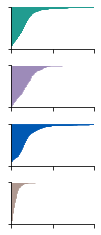

In [259]:
f,ax = plt.subplots(figsize=(1.5, 4),nrows=4, sharex = True, gridspec_kw={"hspace":0.4})

bins= np.arange(-5,40,1)
    
data_to_plot1 = get_run_lengths_for_pseudo_raster(restricted_sorted_runs, color=colors_restricted)
data_to_plot2 = get_run_lengths_for_pseudo_raster(adlib_light_sorted_runs, color=colors_adlib_light)
data_to_plot3 = get_run_lengths_for_pseudo_raster(adlib_dark_sorted_runs, color=colors_adlib_dark)
data_to_plot4 = get_run_lengths_for_pseudo_raster(sucralose_sorted_runs, color=colors_sucralose)

ax[0].add_collection(data_to_plot1)
ax[1].add_collection(data_to_plot2)
ax[2].add_collection(data_to_plot3)
ax[3].add_collection(data_to_plot4)

for axis in ax:
    axis.set_yticklabels([])
    axis.set_xticklabels([])

ax[0].set_yticks([0, len(restricted_sorted_runs)])
ax[1].set_yticks([0, len(adlib_light_sorted_runs)])
ax[2].set_yticks([0, len(adlib_dark_sorted_runs)])
ax[3].set_yticks([0, len(sucralose_sorted_runs)])

ax[0].set_xlim(0,100)
ax[1].set_xticks([0,50,100])


for ax in [ax[0],ax[1], ax[2], ax[3]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#f.savefig(FIGSFOLDER / "raster_ALL.pdf")

In [262]:
len(sucralose_sorted_runs)

279

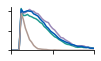

In [287]:
#For Lick frequency

def get_runs_from_all_2 (data):
    mice = get_list_of_mice(data)
    temp_runs = []
    
    for mouse in mice:
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                onset = val["licks"]
                temp_runs.append(get_runs(onset))

    all_runs = []
    for session in temp_runs:
        for run in session:
            all_runs.append(run)
            
    return all_runs

bins= np.arange(-5,40,1)

PVH_restricted_runs_3 = get_runs_from_all_2(PVH_restricted_dark)
VMH_restricted_runs_3 = get_runs_from_all_2(VMH_restricted_dark)
restricted_runs_3 = PVH_restricted_runs_3 + VMH_restricted_runs_3

restricted_hist = np.histogram(tp.flatten_list(restricted_runs_3), bins= bins)
restricted_freq = restricted_hist[0]/len(restricted_runs_3)

PVH_dark_runs_3 = get_runs_from_all_2(PVH_adlib_dark)
VMH_dark_runs_3 = get_runs_from_all_2(VMH_adlib_dark)
dark_runs_3 = PVH_dark_runs_3 + VMH_dark_runs_3

dark_hist = np.histogram(tp.flatten_list(dark_runs_3), bins= bins)
dark_freq = dark_hist[0]/len(dark_runs_3)

PVH_light_runs_3 = get_runs_from_all_2(PVH_adlib_light)
VMH_light_runs_3 = get_runs_from_all_2(VMH_adlib_light)
light_runs_3 = PVH_light_runs_3 + VMH_light_runs_3

light_hist = np.histogram(tp.flatten_list(light_runs_3), bins= bins)
light_freq = light_hist[0]/len(light_runs_3)

PVH_sucralose_runs_3 = get_runs_from_all_2(PVH_adlib_sucralose)
VMH_sucralose_runs_3 = get_runs_from_all_2(VMH_adlib_sucralose)
sucralose_runs_3 = PVH_sucralose_runs_3 + VMH_sucralose_runs_3

sucralose_hist = np.histogram(tp.flatten_list(sucralose_runs_3), bins= bins)
sucralose_freq = sucralose_hist[0]/len(sucralose_runs_3)

f, ax = plt.subplots(figsize=[1.5, 0.8])

ax.plot(restricted_freq, color=colors_restricted)
ax.plot(light_freq, color=colors_adlib_light)
ax.plot(dark_freq, color=colors_adlib_dark)
ax.plot(sucralose_freq,  color=colors_sucralose)

ax.set_xlim(0,40)
ax.set_xticks([0,20,40])

ax.set_ylim(0,5.6)
ax.set_yticks([0, 2.5, 5])

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#f.savefig(FIGSFOLDER / "lick_frequency_ALL.pdf")

In [263]:
bins= np.arange(-5,40,1)

restricted_hist = np.histogram(tp.flatten_list(restricted_runs2), bins= bins)
light_hist = np.histogram(tp.flatten_list(light_runs2), bins= bins)
dark_hist = np.histogram(tp.flatten_list(dark_runs2), bins= bins)
sucralose_hist = np.histogram(tp.flatten_list(sucralose_runs2), bins= bins)

restricted_freq = restricted_hist[0]/len(restricted_runs2)
light_freq = light_hist[0]/len(light_runs2)
dark_freq = light_hist[0]/len(dark_runs2)
sucralose_freq = sucralose_hist[0]/len(sucralose_runs2)

f, ax = plt.subplots(figsize=[1.5, 0.8])

ax.plot(restricted_freq, color=colors_restricted)
ax.plot(light_freq, color=colors_adlib_light)
ax.plot(dark_freq, color=colors_adlib_dark)
ax.plot(sucralose_freq,  color=colors_sucralose)

ax.set_xlim(0,4)
ax.set_xticks([0,20,40])

ax.set_ylim(0,5.6)
ax.set_yticks([0, 2.5, 5])

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

C:\Users\kvo019\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: '<' not supported between instances of 'list' and 'int'

OLD STUFF BELOW THIS

In [ ]:
#getting snips
PVH_restricted_full = get_snips(PVH_restricted_dark)
PVH_dark_full = get_snips(PVH_adlib_dark)
PVH_light_full = get_snips(PVH_adlib_light)
PVH_sucralose_full = get_snips(PVH_adlib_sucralose)

VMH_restricted_full = get_snips(VMH_restricted_dark)
VMH_dark_full = get_snips(VMH_adlib_dark)
VMH_light_full = get_snips(VMH_adlib_light)
VMH_sucralose_full = get_snips(VMH_adlib_sucralose)

In [17]:
def get_licks(data):
    
    mice = get_list_of_mice(data)
    licks = []
    
    for mouse in mice:
        temp_licks = 0
        sessions = 0
        for key, val in data.items():
            if val["mouse_ID"]==mouse:
                #print(val)
                onset = val["licks"]
                temp_licks = temp_licks + len(onset)
                sessions = sessions + 1
        licks.append(temp_licks / sessions)
        
    return np.array(licks)
      
def get_runs(onset, min_run_length=3, run_threshold=8):

    current_list = []
    runs = []
    
    for i in range(1, len(onset)):
        time_diff = (onset[i] - onset[i - 1])
        if time_diff <= run_threshold:
            current_list.append(onset[i])
        else:
            current_list = [onset[i]]
            runs.append(current_list)
            
    no_short_runs = []
    
    for run in runs:
        if len(run) > min_run_length-1:
            no_short_runs.append(run)
     
    time_zeroed_runs = []
    
    for run in no_short_runs:
        time_zeroed_runs.append([t-run[0] for t in run])

    return time_zeroed_runs

def get_runs_from_all (data):
    
    mice = get_list_of_mice(data)
    all_runs = []

    for mouse in mice:
        temp_runs = []
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                onset = val["licks"]
                temp_runs.append(get_runs(onset))

        all_runs.append(tp.flatten_list(temp_runs))

    return all_runs

def sort_runs(runs):
    sort_order = np.argsort([x[-1]for x in runs])
    runs_sorted = [runs[i] for i in sort_order]
    
    return runs_sorted

def get_run_lengths_for_pseudo_raster(runs, color="red"):
    lines = []
    for idx, trial in enumerate(runs):
            lines.append([(trial[0], idx), (trial[-1], idx)])
        
    return LineCollection(lines, color=color, linewidth=0.6)

In [30]:
#getting behavior

#PVH

PVH_restricted_licks = get_licks(PVH_restricted_dark)
PVH_adlib_dark_licks = get_licks(PVH_adlib_dark)
PVH_adlib_light_licks = get_licks(PVH_adlib_light)
PVH_sucralose_licks = get_licks(PVH_adlib_sucralose)

PVH_restricted_runs = get_runs_from_all(PVH_restricted_dark)
PVH_adlib_dark_runs = get_runs_from_all(PVH_adlib_dark)
PVH_adlib_light_runs = get_runs_from_all(PVH_adlib_light)
PVH_sucralose_runs = get_runs_from_all(PVH_adlib_sucralose)

#VMH

VMH_restricted_licks = get_licks(VMH_restricted_dark)
VMH_adlib_dark_licks = get_licks(VMH_adlib_dark)
VMH_adlib_light_licks = get_licks(VMH_adlib_light)
VMH_sucralose_licks = get_licks(PVH_adlib_sucralose)

VMH_restricted_runs = get_runs_from_all(VMH_restricted_dark)
VMH_adlib_dark_runs = get_runs_from_all(VMH_adlib_dark)
VMH_adlib_light_runs = get_runs_from_all(VMH_adlib_light)
VMH_sucralose_runs = get_runs_from_all(VMH_adlib_sucralose)

#COMBINED 
restricted_licks = np.concatenate((PVH_restricted_licks, VMH_restricted_licks))
dark_licks = np.concatenate((PVH_adlib_dark_licks, VMH_adlib_dark_licks))
light_licks = np.concatenate((PVH_adlib_light_licks, VMH_adlib_light_licks))
sucralose_licks = np.concatenate((PVH_sucralose_licks, VMH_sucralose_licks))

# Combine the run arrays
restricted_runs = np.concatenate((PVH_restricted_runs, VMH_restricted_runs))
dark_runs = np.concatenate((PVH_adlib_dark_runs, VMH_adlib_dark_runs))
light_runs = np.concatenate((PVH_adlib_light_runs, VMH_adlib_light_runs))
sucralose_runs = np.concatenate((PVH_sucralose_runs, VMH_sucralose_runs))

bins= np.arange(-5,40,1)

restricted_sorted_runs = sort_runs(tp.flatten_list(restricted_runs))
adlib_dark_sorted_runs = sort_runs(tp.flatten_list(dark_runs))
adlib_light_sorted_runs = sort_runs(tp.flatten_list(light_runs))
sucralose_sorted_runs = sort_runs(tp.flatten_list(sucralose_runs))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [49]:
len(restricted_licks)

14

In [52]:
len(restricted_runs)

14

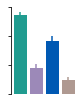

In [35]:
# average licks per session
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(restricted_licks),
        np.mean(light_licks),
        np.mean(dark_licks),
        np.mean(sucralose_licks)
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [restricted_licks,
                             light_licks,
                            dark_licks,
                            sucralose_licks
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
# ax.set_ylim([-25, 0])
ax.set_yticks([0, 500, 1000, 1500])
ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    

#f.savefig(FIGSFOLDER / "licks_per_session_ALL.pdf")


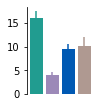

In [58]:
def get_number_of_runs(runs, nsessions):
    return [len(x)/nsessions for x in runs]

def get_average_run_length(runs):
    return [np.mean([len(x) for x in y]) for y in runs]

# average number of runs per session
f, ax = plt.subplots(figsize=(1.2,1.6))

ax.bar([1,2,3,4],
       [np.mean(get_number_of_runs(restricted_runs, 3)),
        np.mean(get_number_of_runs(light_runs, 3)),
        np.mean(get_number_of_runs(dark_runs, 2)),
        np.mean(get_number_of_runs(sucralose_runs, 2))
        ],
       color=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
         )

for x, ydata, color in zip([1,2,3,4],
                            [get_number_of_runs(restricted_runs, 3),
                            get_number_of_runs(light_runs, 3),
                            get_number_of_runs(dark_runs, 2),
                            get_number_of_runs(sucralose_runs, 2)
                            ],
                            [colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose]
                            ):
    
    ax.errorbar(x, np.mean(ydata),
                yerr=np.std(ydata) / np.sqrt(len(ydata)),
                color=color,
                zorder=0
                      ),
    
ax.set_xticks([])
# ax.set_ylim([-25, 0])
#ax.set_yticks([0, 10, 20])
#ax.set_yticklabels([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    
f.savefig(FIGSFOLDER / "runs_per_session_ALL.pdf")


In [72]:
rest_num_runs = get_number_of_runs(restricted_runs, 3)
light_num_runs = get_number_of_runs(light_runs, 3)
dark_num_runs = get_number_of_runs(dark_runs, 2)
sucralose_num_runs = get_number_of_runs(sucralose_runs, 1)

In [77]:
rest_num_runs 

[5.666666666666667,
 25.0,
 17.333333333333332,
 24.0,
 17.333333333333332,
 16.333333333333332,
 18.666666666666668,
 15.666666666666666,
 15.0,
 14.666666666666666,
 6.0,
 15.666666666666666,
 21.333333333333332,
 13.333333333333334]

(<AxesSubplot:>,
 [1, 2, 3, 4],
 [<BarContainer object of 1 artists>,
  <BarContainer object of 1 artists>,
  <BarContainer object of 1 artists>,
  <BarContainer object of 1 artists>],
  <matplotlib.collections.PathCollection at 0x1f415c86820>])

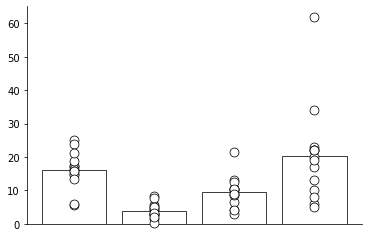

In [73]:
tp.barscatter([rest_num_runs,  light_num_runs, dark_num_runs, sucralose_num_runs])

In [46]:
# Making file with avg number of runs per session
#number_runs_restricted = get_number_of_runs(restricted_runs, 3)
#number_runs_light = get_number_of_runs(light_runs, 3)
#number_runs_dark = get_number_of_runs(dark_runs, 2)
#number_runs_sucralose = get_number_of_runs(sucralose_runs, 2)

#number_runs_all = np.column_stack([number_runs_restricted, number_runs_light, number_runs_dark, number_runs_sucralose])

#file_path = STATSFOLDER / 'number_of_runs_per_session_ALL.csv'

#np.savetxt(file_path, number_runs_all, delimiter=',', fmt='%.6f', header='Restricted Runs, Adlib Light Runs, Adlib Dark Runs, Sucralose Runs')

In [45]:
number_runs_all

array([[ 5.66666667,  4.        ,  4.        , 11.5       ],
       [25.        ,  5.66666667, 21.5       , 11.        ],
       [17.33333333,  8.33333333, 10.5       , 11.        ],
       [24.        ,  4.33333333, 10.5       , 31.        ],
       [17.33333333,  2.66666667, 10.        , 10.        ],
       [16.33333333,  3.        ,  6.5       ,  3.        ],
       [18.66666667,  5.        ,  3.        ,  2.5       ],
       [15.66666667,  3.        ,  9.        ,  8.5       ],
       [15.        ,  7.66666667, 13.        , 17.        ],
       [14.66666667,  1.33333333,  8.5       ,  5.        ],
       [ 6.        ,  0.33333333,  4.        ,  4.        ],
       [15.66666667,  5.        , 12.5       , 11.        ],
       [21.33333333,  3.33333333, 10.5       ,  9.5       ],
       [13.33333333,  2.        ,  9.        ,  6.5       ]])

In [39]:
print((get_number_of_runs(restricted_runs, 3)))

[5.666666666666667, 25.0, 17.333333333333332, 24.0, 17.333333333333332, 16.333333333333332, 18.666666666666668, 15.666666666666666, 15.0, 14.666666666666666, 6.0, 15.666666666666666, 21.333333333333332, 13.333333333333334]


In [40]:
print((get_number_of_runs(light_runs, 3)))

[4.0, 5.666666666666667, 8.333333333333334, 4.333333333333333, 2.6666666666666665, 3.0, 5.0, 3.0, 7.666666666666667, 1.3333333333333333, 0.3333333333333333, 5.0, 3.3333333333333335, 2.0]


In [41]:
print((get_number_of_runs(dark_runs, 3)))

[2.6666666666666665, 14.333333333333334, 7.0, 7.0, 6.666666666666667, 4.333333333333333, 2.0, 6.0, 8.666666666666666, 5.666666666666667, 2.6666666666666665, 8.333333333333334, 7.0, 6.0]
